In [1]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras_hub
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import time

keras.mixed_precision.set_global_policy("mixed_float16")

2025-11-06 14:52:50.326619: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762437170.338264   15968 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762437170.341760   15968 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762437170.352253   15968 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762437170.352262   15968 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1762437170.352264   15968 computation_placer.cc:177] computation placer alr

In [2]:
# General hyperparameters
BATCH_SIZE = 16
NUM_BATCHES = 500
EPOCHS = 1  # Can be set to a higher value for better results
MAX_SEQUENCE_LENGTH = 128
MAX_GENERATION_LENGTH = 200

GPT2_PRESET = "gpt2_base_en"

# LoRA-specific hyperparameters
RANK = 4
ALPHA = 32.0

In [3]:
reddit_ds = tfds.load("reddit_tifu", split="train", as_supervised=True)

I0000 00:00:1762437176.478477   15968 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8923 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:08:00.0, compute capability: 7.5


In [4]:
for document, title in reddit_ds:
    print(document.numpy())
    print(title.numpy())
    break

b"me and a friend decided to go to the beach last sunday. we loaded up and headed out. we were about half way there when i decided that i was not leaving till i had seafood. \n\nnow i'm not talking about red lobster. no friends i'm talking about a low country boil. i found the restaurant and got directions. i don't know if any of you have heard about the crab shack on tybee island but let me tell you it's worth it. \n\nwe arrived and was seated quickly. we decided to get a seafood sampler for two and split it. the waitress bought it out on separate platters for us. the amount of food was staggering. two types of crab, shrimp, mussels, crawfish, andouille sausage, red potatoes, and corn on the cob. i managed to finish it and some of my friends crawfish and mussels. it was a day to be a fat ass. we finished paid for our food and headed to the beach. \n\nfunny thing about seafood. it runs through me faster than a kenyan \n\nwe arrived and walked around a bit. it was about 45min since we a

2025-11-06 14:52:56.668378: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-06 14:52:56.673938: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [5]:
train_ds = (
    reddit_ds.map(lambda document, _: document)
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(tf.data.AUTOTUNE)
)
train_ds = train_ds.take(NUM_BATCHES)

In [6]:
class GPUMemoryCallback(keras.callbacks.Callback):
    def __init__(
        self,
        target_batches,
        print_stats=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.target_batches = target_batches
        self.print_stats = print_stats

        self.memory_usage = []
        self.labels = []

    def _compute_memory_usage(self):
        memory_stats = tf.config.experimental.get_memory_info("GPU:0")
        # Convert bytes to GB and store in list.
        peak_usage = round(memory_stats["peak"] / (2**30), 3)
        self.memory_usage.append(peak_usage)

    def on_epoch_begin(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} start")

    def on_train_batch_begin(self, batch, logs=None):
        if batch in self.target_batches:
            self._compute_memory_usage()
            self.labels.append(f"batch {batch}")

    def on_epoch_end(self, epoch, logs=None):
        self._compute_memory_usage()
        self.labels.append(f"epoch {epoch} end")

In [7]:
def generate_text(model, input_text, max_length=200):
    start = time.time()

    output = model.generate(input_text, max_length=max_length)
    print("\nOutput:")
    print(output)

    end = time.time()
    print(f"Total Time Elapsed: {end - start:.2f}s")

In [8]:
def get_optimizer_and_loss():
    optimizer = keras.optimizers.AdamW(
        learning_rate=5e-5,
        weight_decay=0.01,
        epsilon=1e-6,
        global_clipnorm=1.0,  # Gradient clipping.
    )
    # Exclude layernorm and bias terms from weight decay.
    optimizer.exclude_from_weight_decay(var_names=["bias"])
    optimizer.exclude_from_weight_decay(var_names=["gamma"])
    optimizer.exclude_from_weight_decay(var_names=["beta"])

    loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return optimizer, loss

In [9]:
preprocessor = keras_hub.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=MAX_SEQUENCE_LENGTH,
)
gpt2_lm = keras_hub.models.GPT2CausalLM.from_preset(
    "gpt2_base_en", preprocessor=preprocessor
)

gpt2_lm.summary()

Preprocessor: "gpt2_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                                │                       Vocab size: 50,257 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gpt2_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 768)         │     124,439,808 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      38,597,376 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,439,808 (474.70 MB)

 Trainable params: 124,439,808 (474.70 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
gpu_memory_callback = GPUMemoryCallback(
    target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
    print_stats=True,
)

optimizer, loss = get_optimizer_and_loss()

gpt2_lm.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

In [11]:
gpt2_lm.fit(train_ds, epochs=EPOCHS, callbacks=[gpu_memory_callback])
gpt2_lm_memory_usage = gpu_memory_callback.memory_usage

I0000 00:00:1762437198.575780   16083 service.cc:152] XLA service 0x71f754069c80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762437198.575809   16083 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2025-11-06 14:53:19.006663: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-06 14:53:19.486042: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1762437202.509471   16083 cuda_dnn.cc:529] Loaded cuDNN version 91002


  1/500 ━━━━━━━━━━━━━━━━━━━━ 5:35:27 40s/step - accuracy: 0.2884 - loss: 3.9084

I0000 00:00:1762437221.364476   16083 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


484/500 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step - accuracy: 0.3090 - loss: 3.4181

2025-11-06 14:54:55.372843: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-06 14:54:55.373985: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


500/500 ━━━━━━━━━━━━━━━━━━━━ 117s 154ms/step - accuracy: 0.3170 - loss: 3.3554


In [13]:
generate_text(gpt2_lm, "I like basketball", max_length=MAX_GENERATION_LENGTH)
generate_text(gpt2_lm, "That Italian restaurant is", max_length=MAX_GENERATION_LENGTH)


Output:
I like basketball. 

so i have a friend that loves to play basketball. 

so this morning he came up to my room and started playing basketball, which is a little different than basketball. 

my friend starts playing basketball and i start playing with him. 

so i play with him and he starts playing basketball, so i start playing basketball. 

i start playing with him and he starts playing basketball with me, so i'm like okay. 

my friend says, "hey, what's going on? 
Total Time Elapsed: 7.26s

Output:
That Italian restaurant is located at a strip mall and they're all about serving food and drinks. 

i'm in the middle of eating a delicious pizza and the pizza comes out of the oven with a pizza crust on top. i'm in a hurry to get my food to the pizza oven, so i grab a pizza crust from one of the tables and begin to roll it over. i'm about to roll it over and it just falls to the floor in a heap, but i'm still trying to roll it over so i can get the pizza to my mouth. 

i'm trying

In [14]:
import math


class LoraLayer(keras.layers.Layer):
    def __init__(
        self,
        original_layer,
        rank=8,
        alpha=32,
        trainable=False,
        **kwargs,
    ):
        # We want to keep the name of this layer the same as the original
        # dense layer.
        original_layer_config = original_layer.get_config()
        name = original_layer_config["name"]

        kwargs.pop("name", None)

        super().__init__(name=name, trainable=trainable, **kwargs)

        self.rank = rank
        self.alpha = alpha

        self._scale = alpha / rank

        self._num_heads = original_layer_config["output_shape"][-2]
        self._hidden_dim = self._num_heads * original_layer_config["output_shape"][-1]

        # Layers.

        # Original dense layer.
        self.original_layer = original_layer
        # No matter whether we are training the model or are in inference mode,
        # this layer should be frozen.
        self.original_layer.trainable = False

        # LoRA dense layers.
        self.A = keras.layers.Dense(
            units=rank,
            use_bias=False,
            # Note: the original paper mentions that normal distribution was
            # used for initialization. However, the official LoRA implementation
            # uses "Kaiming/He Initialization".
            kernel_initializer=keras.initializers.VarianceScaling(
                scale=math.sqrt(5), mode="fan_in", distribution="uniform"
            ),
            trainable=trainable,
            name=f"lora_A",
        )
        # B has the same `equation` and `output_shape` as the original layer.
        # `equation = abc,cde->abde`, where `a`: batch size, `b`: sequence
        # length, `c`: `hidden_dim`, `d`: `num_heads`,
        # `e`: `hidden_dim//num_heads`. The only difference is that in layer `B`,
        # `c` represents `rank`.
        self.B = keras.layers.EinsumDense(
            equation=original_layer_config["equation"],
            output_shape=original_layer_config["output_shape"],
            kernel_initializer="zeros",
            trainable=trainable,
            name=f"lora_B",
        )

    def call(self, inputs):
        original_output = self.original_layer(inputs)
        if self.trainable:
            # If we are fine-tuning the model, we will add LoRA layers' output
            # to the original layer's output.
            lora_output = self.B(self.A(inputs)) * self._scale
            return original_output + lora_output

        # If we are in inference mode, we "merge" the LoRA layers' weights into
        # the original layer's weights - more on this in the text generation
        # section!
        return original_output

In [15]:
del gpt2_lm
del optimizer
del loss

# This resets "peak" memory usage to "current" memory usage.
tf.config.experimental.reset_memory_stats("GPU:0")

# Load the original model.
preprocessor = keras_hub.models.GPT2CausalLMPreprocessor.from_preset(
    "gpt2_base_en",
    sequence_length=128,
)
lora_model = keras_hub.models.GPT2CausalLM.from_preset(
    "gpt2_base_en",
    preprocessor=preprocessor,
)

In [16]:
for layer_idx in range(lora_model.backbone.num_layers):
    # Change query dense layer.
    decoder_layer = lora_model.backbone.get_layer(f"transformer_layer_{layer_idx}")
    self_attention_layer = decoder_layer._self_attention_layer
    # Allow mutation to Keras layer state.
    self_attention_layer._tracker.locked = False

    # Change query dense layer.
    self_attention_layer._query_dense = LoraLayer(
        self_attention_layer._query_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

    # Change value dense layer.
    self_attention_layer._value_dense = LoraLayer(
        self_attention_layer._value_dense,
        rank=RANK,
        alpha=ALPHA,
        trainable=True,
    )

In [17]:
lora_model(preprocessor(["LoRA is very useful for quick LLM finetuning"])[0])
pass

In [18]:
for layer in lora_model._flatten_layers():
    lst_of_sublayers = list(layer._flatten_layers())

    if len(lst_of_sublayers) == 1:  # "leaves of the model"
        if layer.name in ["lora_A", "lora_B"]:
            layer.trainable = True
        else:
            layer.trainable = False

In [19]:
lora_model.summary()

Preprocessor: "gpt2_causal_lm_preprocessor_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gpt2_tokenizer (GPT2Tokenizer)                                │                       Vocab size: 50,257 │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "gpt2_causal_lm_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gpt2_backbone (GPT2Backbone)  │ (None, None, 768)         │     124,587,264 │ padding_mask[0][0],        │
│                               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 50257)       │      38,597,376 │ gpt2_backbone[0][0]        │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 124,587,264 (475.26 MB)

 Trainable params: 147,456 (576.00 KB)

 Non-trainable params: 124,439,808 (474.70 MB)

In [20]:
gpu_memory_callback = GPUMemoryCallback(
    target_batches=[5, 10, 25, 50, 100, 150, 200, 300, 400, 500],
    print_stats=True,
)

optimizer, loss = get_optimizer_and_loss()

lora_model.compile(
    optimizer=optimizer,
    loss=loss,
    weighted_metrics=["accuracy"],
)

lora_model.fit(
    train_ds,
    epochs=EPOCHS,
    callbacks=[gpu_memory_callback],
)
lora_model_memory_usage = gpu_memory_callback.memory_usage

2025-11-06 14:57:32.141125: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


484/500 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - accuracy: 0.2851 - loss: 3.6705

2025-11-06 14:58:26.628227: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-06 14:58:26.629383: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


500/500 ━━━━━━━━━━━━━━━━━━━━ 69s 91ms/step - accuracy: 0.2921 - loss: 3.5878


/tmp/ipykernel_15968/1400903047.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


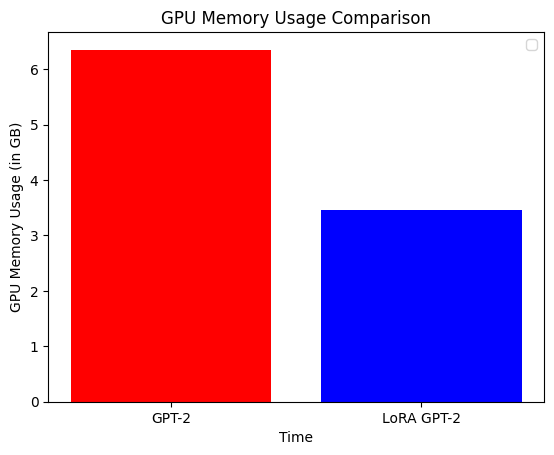

In [21]:
plt.bar(
    ["GPT-2", "LoRA GPT-2"],
    [max(gpt2_lm_memory_usage), max(lora_model_memory_usage)],
    color=["red", "blue"],
)

plt.xlabel("Time")
plt.ylabel("GPU Memory Usage (in GB)")

plt.title("GPU Memory Usage Comparison")
plt.legend()
plt.show()

In [22]:
for layer_idx in range(lora_model.backbone.num_layers):
    self_attention_layer = lora_model.backbone.get_layer(
        f"transformer_layer_{layer_idx}"
    )._self_attention_layer

    # Merge query dense layer.
    query_lora_layer = self_attention_layer._query_dense

    A_weights = query_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = query_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    query_lora_layer.original_layer.kernel.assign_add(increment_weights)

    # Merge value dense layer.
    value_lora_layer = self_attention_layer._value_dense

    A_weights = value_lora_layer.A.kernel  # (768, 1) (a, b)
    B_weights = value_lora_layer.B.kernel  # (1, 12, 64) (b, c, d)
    increment_weights = tf.einsum("ab,bcd->acd", A_weights, B_weights) * (ALPHA / RANK)
    value_lora_layer.original_layer.kernel.assign_add(increment_weights)

    # Put back in place the original layers with updated weights
    self_attention_layer._query_dense = query_lora_layer.original_layer
    self_attention_layer._value_dense = value_lora_layer.original_layer

In [23]:
# Freezing weights not necessary during generation since no weights are updated.
generate_text(lora_model, "I like basketball", max_length=MAX_GENERATION_LENGTH)
generate_text(
    lora_model, "That Italian restaurant is", max_length=MAX_GENERATION_LENGTH
)


Output:
I like basketball, so I decided to try to make some basketball fun. I was playing basketball at the school gym when I saw a group of guys with basketball caps on their heads and I thought, "hey, what are these guys doing?" I didn't know they were basketball players, but I was so nervous. So I asked my coach what was wrong, and he said, "it's basketball."
The basketball was so fun.
My mom had a really bad night and I was so nervous. I didn't know why she was so nervous.
I was really scared. My mom said, "you know what, you know what, you can do something stupid, you know what, I'll do something stupid, and you'll be so happy."
So I went out with her and we had a basketball game.
Total Time Elapsed: 6.35s

Output:
That Italian restaurant is called "Casa" and is located at the corner of the old Italian street and the old street, so you can see the main street. The menu is pretty much identical to what it used to be and there are a ton of different things. I have a couple of diffe